In [106]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from tqdm import tqdm, trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
%cd jax-morph

/n/home10/rdeshpande/morphogenesis/jax-morph


In [110]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_stress, draw_circles_ctype, draw_circles

import matplotlib.pyplot as plt

# Cell State

In [111]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array
    mechanical_stress:  jax.Array
    field:              jax.Array

In [138]:
N_DIM = 2
N_CHEM = 10
N_HIDDEN = 32
N_CTYPES = 1

N = 100
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()
istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,N_CTYPES)).at[0].set(1.),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    field=          np.zeros(shape=(N,1)),
    mechanical_stress=np.zeros(shape=(N,1)),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [139]:
class ChemicalField(jxm.SimulationStep):
    def return_logprob(self) -> bool:
        return False
    @jax.named_scope("jax_morph.ChemicalField")
    def __call__(self, state, *, key=None, **kwargs):
        center = np.average(state.position, axis=0)
        chemfield_disp = jax.vmap(state.displacement, (0, None))(state.position, center)
        chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
        chemfield = 1.0/(2 + .4*np.power(chemfield_disp, 2))
        chemfield = np.where(state.celltype.sum(1)[:,None] > 0, chemfield[:, np.newaxis], 0.) 
        state = eqx.tree_at(lambda s: s.field, state, chemfield)
        return state

In [148]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),
        ChemicalField(),
        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),
        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),
        jxm.cell.sensing.LocalMechanicalStress(mech_potential),
        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=.2), #WORKS LESS WELL, BUT STILL WORKS -- ???
        #jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),
        jxm.cell.sensing.LocalChemicalGradients(),
        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad','mechanical_stress', 'division', 'radius'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))*s.field},
                            expr_level_decay=1.,
                            interaction_init=jax.nn.initializers.constant(0.0)
                            ),     
    ])

In [149]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(model, istate, subkey, N_ADD)

(<Figure size 800x800 with 2 Axes>, <Axes: >)

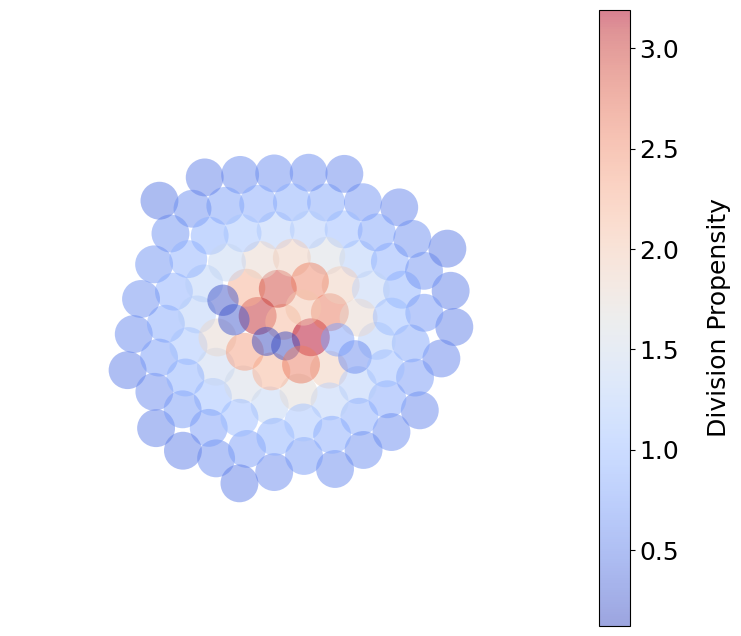

In [150]:
draw_circles_divrate(s)

# REINFORCE Loss

In [151]:
from functools import partial

In [152]:
@eqx.filter_jit
def reinforce_loss(model, istate, *, cost_fn, key, n_steps=1, BATCH_SIZE=1, GAMMA=.9, LAMBDA=.001):

    subkeys = jax.random.split(key, BATCH_SIZE)
    subkeys = np.asarray(subkeys)

    vsim = jax.vmap(partial(jxm.simulate, history=True), (None, None, 0, None))
    trajectory, logp = vsim(model, istate, subkeys, n_steps)


    istate = jtu.tree_map(lambda x: np.repeat(x[None,None,:,:],BATCH_SIZE,0), istate)

    trajectory = jtu.tree_map(lambda *v: np.concatenate(v,1), *[istate, trajectory])


    cost = jax.vmap(cost_fn)(trajectory)


    #discounted costs
    def _returns_rec(rewards):
        Gs=[]
        G=0
        for r in rewards[::-1]:
            G = r+G*GAMMA
            Gs.append(G)

        return np.array(Gs)[::-1]
    
    
    #cost = jax.vmap(_returns_rec)(cost)

    #cost = (cost-cost.mean(-1, keepdims=True))/(cost.std(-1, keepdims=True)+1e-8)


    #no - sign because we assume a cost instead of a reward
    #loss = np.sum(jax.lax.stop_gradient(cost)*logp)
    loss = np.sum(cost)

    #L1 penalty on weights
    reg = jax.tree_map(lambda x: np.abs(x).sum(), eqx.filter(model, eqx.is_array))
    reg = jax.tree_util.tree_reduce(lambda x,y: x+y, reg)

    return loss + LAMBDA*reg

## Cost Functions

In [153]:
def division_cv(trajectory):
    cost = np.std(trajectory.division[-1, :])/np.mean(trajectory.division[-1, :])
    return cost

# Training

In [154]:
import optax
from tqdm import trange
from functools import partial

In [155]:
EPOCHS = 200
BATCH_SIZE = 4


COST_FN = division_cv
LAMBDA=0.


opt_model = model


optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, subkey = jax.random.split(key)

rl, g = eqx.filter_value_and_grad(reinforce_loss)(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

l = COST_FN(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()


rlosses = [float(rl)]
losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    try:
        # g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

        updates, opt_state = optimizer.update(g, opt_state, opt_model)
        opt_model = eqx.apply_updates(opt_model, updates)

        key, subkey = jax.random.split(key)

        rl, g = eqx.filter_value_and_grad(reinforce_loss)(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

        l = COST_FN(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()


        rlosses.append(float(rl))
        losses.append(float(l))
        pbar.set_description(f'Loss: {l:.3f}')

    except FloatingPointError:
        print('NaN or Overflow')
        break

    except KeyboardInterrupt:
        print('Interrupted')
        break

Loss: 0.256:  84%|███████████████████████████████████████████████████████████▋           | 168/200 [07:08<01:21,  2.55s/it]

Interrupted


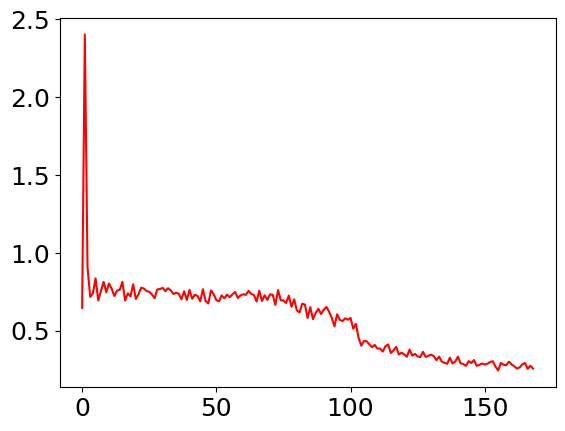

In [156]:
plt.plot(losses, 'r');

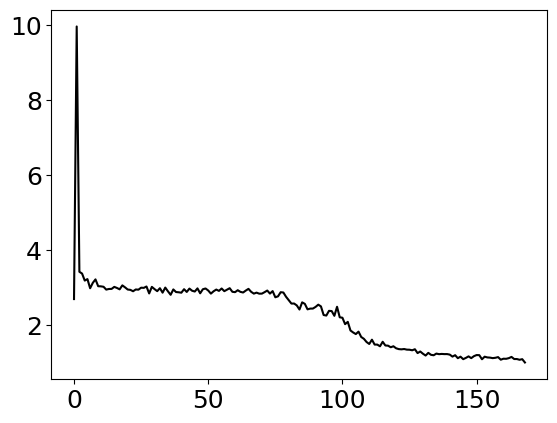

In [157]:
plt.plot(rlosses, 'k');

In [158]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps):

    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))

    fstate, _ = vsim(model, istate, subkeys, n_sim_steps)

    cost = np.std(fstate.division, axis=1)/np.mean(fstate.division, axis=1)
    return cost.flatten().tolist()

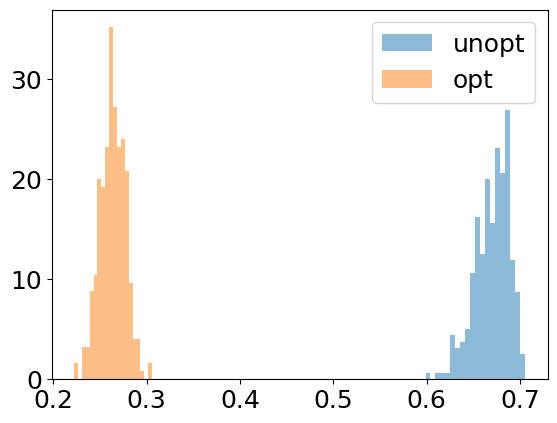

In [159]:
subkeys = np.asarray(jax.random.split(key, 300))

mcost = _final_cost_distribution(model, istate, subkeys, N_ADD)
ocost = _final_cost_distribution(opt_model, istate, subkeys, N_ADD)

plt.hist(mcost, bins=20, alpha=.5, density=True, label="unopt")
plt.hist(ocost, bins=20, alpha=.5, density=True, label="opt");
plt.legend()

In [160]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_model, istate, subkey, N_ADD)

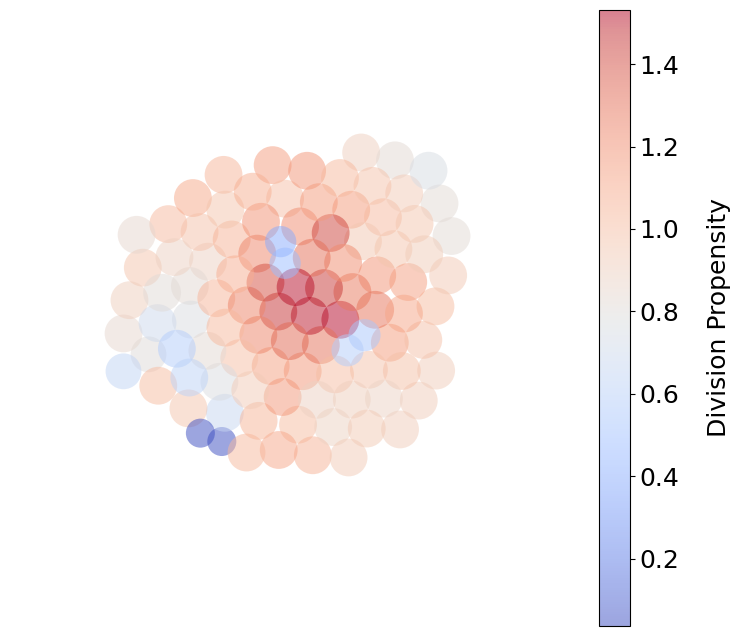

In [161]:
draw_circles_divrate(s);

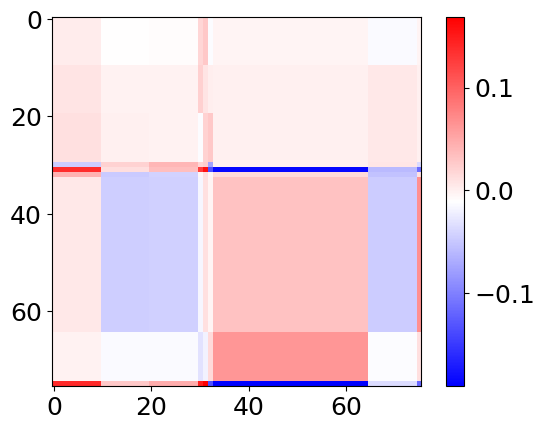

In [162]:
plt.imshow(opt_model[-1].interaction_matrix, cmap='bwr')
plt.colorbar();

100%|██████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:29<00:00,  1.01it/s]


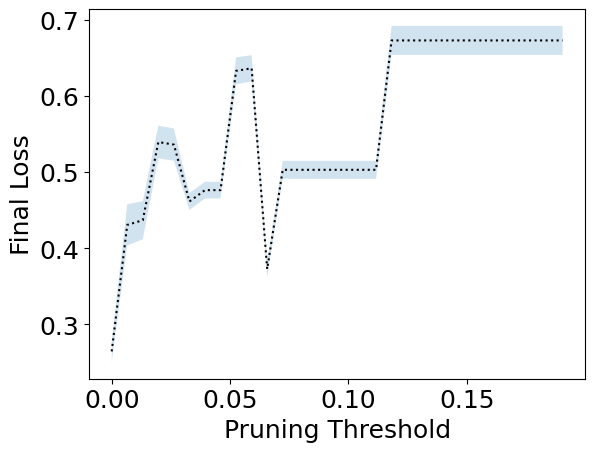

In [163]:
interact_mat = opt_model[-1].interaction_matrix
thrs = np.linspace(0., np.abs(interact_mat).max(), 30)
subkeys = np.asarray(jax.random.split(key, 100))

cc = []
for thr in tqdm(thrs):
    pm = eqx.tree_at(lambda m: m[-1].interaction_matrix, opt_model, np.where(np.abs(interact_mat)<thr, 0., interact_mat))
    cc += [_final_cost_distribution(pm, istate, subkeys, N_ADD)]


plt.plot(thrs, np.asarray(cc).mean(-1).tolist(), 'k:')
plt.fill_between(thrs, (np.asarray(cc).mean(-1) - np.asarray(cc).std(-1)).tolist(), (np.asarray(cc).mean(-1) + np.asarray(cc).std(-1)).tolist(), alpha=.2)

plt.xlabel('Pruning Threshold')
plt.ylabel('Final Loss');

In [171]:
W = opt_model[-1].interaction_matrix
NUM_IN = N_CHEM + N_CHEM*2 + 3
NUM_OUT = N_CHEM + 1
node_colors = ["violet"]*NUM_IN + ["limegreen"]*N_HIDDEN + ["blue"] + ["darkorange"]*(NUM_OUT - 1)
node_sizes = [100]*NUM_IN + [30]*N_HIDDEN + [100]*NUM_OUT

Text(0.5, 1.0, 'Gene network')

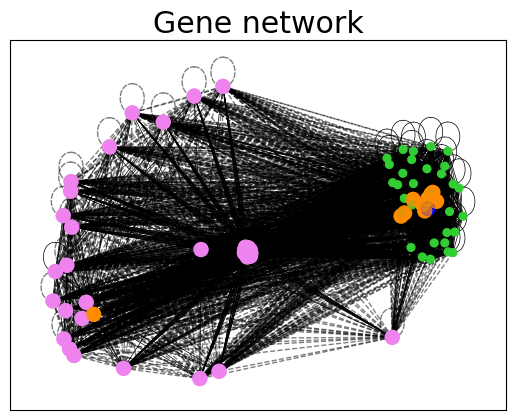

In [172]:
# Visualize network
import networkx as nx
G = nx.from_numpy_array(W)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']>0], with_labels=False, node_size=node_sizes, width=.5, alpha=1., node_color=node_colors)
nx.draw_networkx(G, pos, connectionstyle="arc3,rad=0.1", style='--', edgelist=[(v, u) for u,v,w in G.edges(data=True) if w['weight']<0], with_labels=False, node_size=node_sizes, width=1., alpha=.5, node_color=node_colors)
plt.title("Gene network")